In [1]:
from torchvision import transforms
import torch

import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import CIFAR10

from models.model_final import VisionTransformer, CONFIGS

In [ ]:
config = CONFIGS["ViT-Ours_res0"]

model = VisionTransformer(config, num_classes=10)
checkpoint_path = "/home/sichongjie/sichongjie-sub/ViT_torch/output_final/cifar10_No_24_checkpoint.bin" 
state_dict = torch.load(checkpoint_path, map_location="cpu")  # 加载权重文件
model.load_state_dict(state_dict)  # 加载模型参数
print(f"Loaded fine-tuned model from {checkpoint_path}")
model.eval()

Loaded fine-tuned model from /home/sichongjie/sichongjie-sub/ViT_torch/output_final/cifar10_No_24_checkpoint.bin


/tmp/ipykernel_1779450/4289613789.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location="cpu")  # 加载权重文件


VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 384, kernel_size=(4, 4), stride=(4, 4))
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0-7): 8 x Block(
          (attention_norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=384, out_features=384, bias=True)
            (fc2): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (out): Linear(in_features=384, out_features=384, bias=True)
     

In [3]:
# 假设 embedding_layer 是模型的嵌入层
embedding_weights = model.transformer.embeddings.patch_embeddings.weight.data  # Shape: [D, C, P, P]
print(embedding_weights.shape)

torch.Size([384, 3, 4, 4])


In [4]:
from sklearn.decomposition import PCA

C = 3
P = 4

# 展平权重矩阵
weights_flattened = embedding_weights.view(embedding_weights.size(0), -1).cpu().numpy()  # Shape: [D, C*P*P]

# 使用 PCA 提取主成分
pca = PCA(n_components=28)  # 提取前 28 个主成分
principal_components = pca.fit_transform(weights_flattened)  # Shape: [28, C*P*P]

# 恢复为原始形状（假设补丁大小为 P x P x C）
principal_components_images = principal_components.reshape(-1, C, P, P)  # Shape: [28, C, P, P]

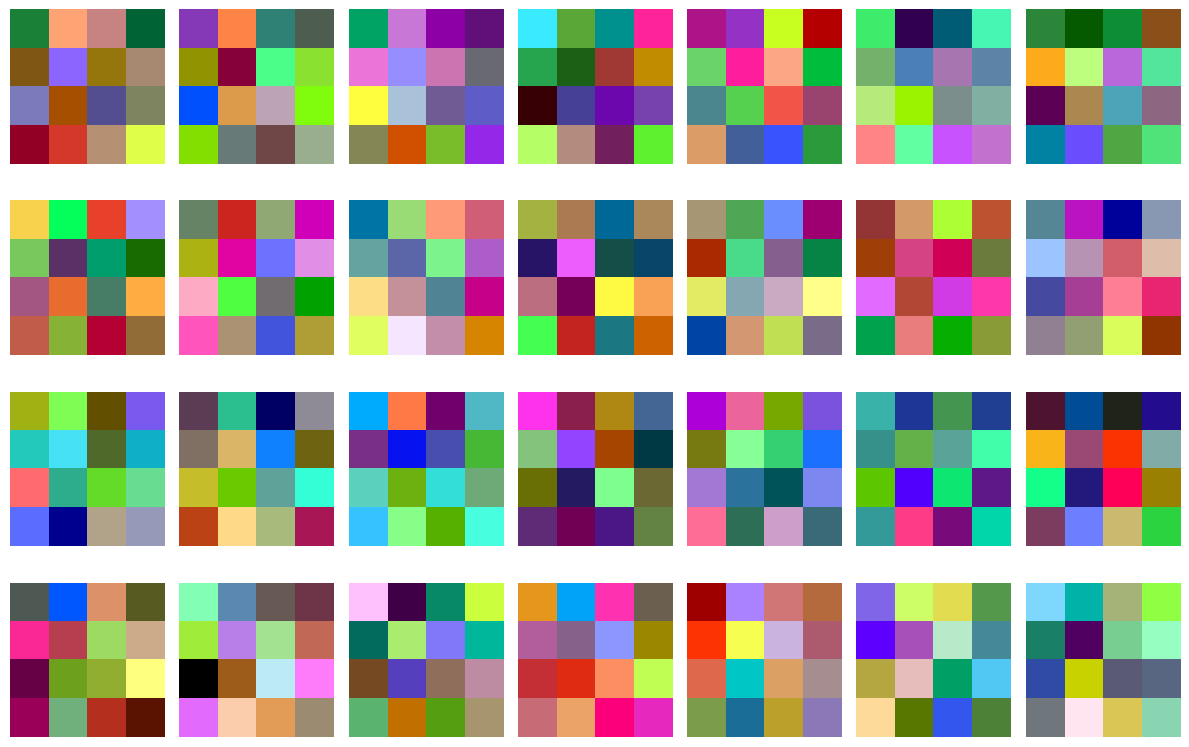

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    return (image - min_val) / (max_val - min_val + 1e-5)  # 加1e-5避免除以0

# 归一化 principal_components_images
normalized_images = []
for img in principal_components_images:
    if C == 1:  # 单通道
        normalized_images.append(normalize_image(img[0]))  # Shape: [P, P]
    else:  # 多通道
        normalized_images.append(np.stack([normalize_image(channel) for channel in img], axis=0))
normalized_images = np.array(normalized_images)

n_rows = 4  
n_cols = 7  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))

im = None  
for i, ax in enumerate(axes.flat):
    if i < normalized_images.shape[0]:
        image = normalized_images[i]
        if C == 1:
            im = ax.imshow(image, cmap='gray')  
        else:
            im = ax.imshow(np.transpose(image, (1, 2, 0)))  
        ax.axis('off')  
    else:
        ax.axis('off')  

if C == 1:  # 只有单通道图像才添加 colorbar
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
    cbar.set_label('Normalized Value')

plt.tight_layout()
plt.show()
